## Imports

In [76]:
import os
import argparse
import random
import math
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from scipy.ndimage import gaussian_filter
from dataset.medical_zero import MedTestDataset, MedTrainDataset
from CLIP.clip import create_model
from CLIP.tokenizer import tokenize
from CLIP.adapter import CLIP_Inplanted
from PIL import Image
from sklearn.metrics import precision_recall_curve
from loss import FocalLoss, BinaryDiceLoss
from utils import augment, encode_text_with_prompt_ensemble
from prompt import REAL_NAME
import matplotlib.pyplot as plt
import cv2

import warnings
warnings.filterwarnings("ignore")

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

CLASS_INDEX = {'Brain':3, 'Liver':2, 'Retina_RESC':1, 'Retina_OCT2017':-1, 'Chest':-2, 'Histopathology':-3}
CLASS_INDEX_INV = {3:'Brain', 2:'Liver', 1:'Retina_RESC', -1:'Retina_OCT2017', -2:'Chest', -3:'Histopathology'}

In [3]:
args = {
    'model_name': 'ViT-L-14-336',
    'pretrain': 'openai',
    'obj': 'Liver',
    'data_path': './data/',
    'batch_size': 1,
    'img_size': 240,
    'save_path': './ckpt/zero-shot/',
    'epoch': 50,
    'learning_rate': 0.0001,
    'features_list': [6, 12, 18, 24],
    'seed': 111
}

In [4]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
setup_seed(args['seed'])

In [5]:
clip_model = create_model(model_name=args['model_name'], 
                          img_size=args['img_size'], 
                          device=device, 
                          pretrained=args['pretrain'], 
                          require_pretrained=True)
clip_model.eval()

model = CLIP_Inplanted(clip_model=clip_model, features=args['features_list']).to(device)
model.eval()

checkpoint = torch.load(os.path.join(f'{args["save_path"]}', f'{args["obj"]}.pth'))
model.seg_adapters.load_state_dict(checkpoint["seg_adapters"])
model.det_adapters.load_state_dict(checkpoint["det_adapters"])

<All keys matched successfully>

In [6]:
text_feature_list = [0]
# text prompt
with torch.cuda.amp.autocast(), torch.no_grad():
    for i in [1,2,3,-3,-2,-1]:
        text_feature = encode_text_with_prompt_ensemble(clip_model, REAL_NAME[CLASS_INDEX_INV[i]], device)
        text_feature_list.append(text_feature)
    
text_features = text_feature_list[CLASS_INDEX[args['obj']]]

In [7]:
from torchvision import transforms

transform_image = transforms.Compose([
        transforms.Resize((args['img_size'], args['img_size']), Image.BICUBIC),
        transforms.ToTensor(),
    ])

transform_mask = transforms.Compose(
            [transforms.Resize((args['img_size'], args['img_size']), Image.NEAREST),
             transforms.ToTensor()])

In [8]:
loss_focal = FocalLoss()
loss_dice = BinaryDiceLoss()
loss_bce = torch.nn.BCEWithLogitsLoss()

In [9]:
def generate_grad_cam(model, ori_image, image_label, ori_mask):
    """
    :param model: deep learning network(ResNet DataParallel object)
    :param ori_image: the original image
    :return: gradient class activation map
    """
    input_image = transform_image(ori_image)
    input_image = input_image.unsqueeze(0) # 1, 3, 240, 240
    input_image = input_image.to(device)
    
    mask = transform_mask(ori_mask)
    mask = mask.unsqueeze(0) # 1, 1 , 240 , 240
    mask = mask.to(device)
    
    feature = None
    gradient = None

    def func_f(module, input, output):
        nonlocal feature
        feature = output.data.cpu().numpy()

    def func_b(module, grad_in, grad_out):
        nonlocal gradient
        gradient = grad_out[0].data.cpu().numpy()

    model.seg_adapters[3].fc1.register_forward_hook(func_f)
    model.seg_adapters[3].fc1.register_backward_hook(func_b)

    with torch.cuda.amp.autocast():
        _, seg_patch_tokens, det_patch_tokens = model(input_image)
        seg_patch_tokens = [p[0, 1:, :] for p in seg_patch_tokens]
        det_patch_tokens = [p[0, 1:, :] for p in det_patch_tokens]
        
        # image level
        det_loss = 0
        image_label = image_label.to(device)
        for layer in range(len(det_patch_tokens)):
            det_patch_tokens[layer] = det_patch_tokens[layer] / det_patch_tokens[layer].norm(dim=-1, keepdim=True)
            anomaly_map = (100.0 * det_patch_tokens[layer] @ text_features).unsqueeze(0)    
            anomaly_map = torch.softmax(anomaly_map, dim=-1)[:, :, 1]
            anomaly_score = torch.mean(anomaly_map, dim=-1)
            det_loss += loss_bce(anomaly_score, image_label)
            
        if CLASS_INDEX[args['obj']] > 0:
            # pixel level
            seg_loss = 0
            mask = mask.to(device)
            mask[mask > 0.5], mask[mask <= 0.5] = 1, 0
            for layer in range(len(seg_patch_tokens)):
                seg_patch_tokens[layer] = seg_patch_tokens[layer] / seg_patch_tokens[layer].norm(dim=-1, keepdim=True)
                # print(seg_patch_tokens[layer].shape, text_feature_list[seg_idx].shape) # torch.Size([289, 768]) torch.Size([768, 2])
                anomaly_map = (100.0 * seg_patch_tokens[layer] @ text_features).unsqueeze(0)
                B, L, C = anomaly_map.shape
                H = int(np.sqrt(L))
                anomaly_map = F.interpolate(anomaly_map.permute(0, 2, 1).view(B, 2, H, H),
                                            size=args['img_size'], mode='bilinear', align_corners=True)
                anomaly_map = torch.softmax(anomaly_map, dim=1)
                # return anomaly_map, mask
                seg_loss += loss_focal(anomaly_map, mask)
                seg_loss += loss_dice(anomaly_map[:, 1, :, :], mask)
                
            loss = seg_loss + det_loss # = focal(seg_out, mask) + bce(det_out, y)
            loss.requires_grad_(True)
            loss.backward()
            
        else:
            loss = det_loss
            loss.requires_grad_(True)
            loss.backward()

    return feature, gradient, seg_patch_tokens, det_patch_tokens

In [12]:
img_path = "./data/Brain_AD/test/Ungood/img/00002_60.png"
mask_path = "./data/Brain_AD/test/Ungood/anomaly_mask/00002_60.png"

In [57]:
ori_image = Image.open(img_path).convert('RGB')
image_label = torch.Tensor([1])
mask = Image.open(img_path).convert('L')
feature, gradient, seg_patch_tokens, det_patch_tokens = generate_grad_cam(model, ori_image, image_label, mask)

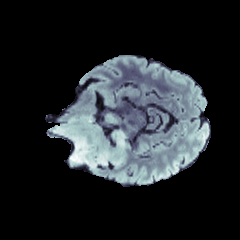

In [58]:
ori_image

In [ ]:
print(feature.shape)
print(gradient.shape)

In [14]:
seg_patch_tokens[0].shape

torch.Size([289, 768])

In [ ]:
text_feature

In [77]:
len(seg_patch_tokens)

4

In [78]:
anomaly_maps = []
with torch.cuda.amp.autocast():
    for layer in range(len(seg_patch_tokens)):
        seg_patch_tokens[layer] /= seg_patch_tokens[layer].norm(dim=-1, keepdim=True)
        anomaly_map = (100.0 * seg_patch_tokens[layer] @ text_features).unsqueeze(0)
        B, L, C = anomaly_map.shape
        H = int(np.sqrt(L))
        anomaly_map = F.interpolate(anomaly_map.permute(0, 2, 1).view(B, 2, H, H),
                                    size=args['img_size'], mode='bilinear', align_corners=True)
        anomaly_map = torch.softmax(anomaly_map, dim=1)[:, 1, :, :]
        anomaly_maps.append(anomaly_map)

In [79]:
print(len(anomaly_maps))
print(anomaly_maps[0].shape)

4
torch.Size([1, 240, 240])


In [30]:
anomaly_map = torch.stack(anomaly_maps, dim=0)
anomaly_map = anomaly_map.sum(dim=0)
anomaly_map.shape

torch.Size([1, 240, 240])

In [ ]:
# anomaly_map = None
# with torch.cuda.amp.autocast():
#     layer=0
#     seg_patch_tokens[layer] = seg_patch_tokens[layer] / seg_patch_tokens[layer].norm(dim=-1, keepdim=True)
#     # print(seg_patch_tokens[layer].shape, text_feature_list[seg_idx].shape) # torch.Size([289, 768]) torch.Size([768, 2])
#     anomaly_map = (100.0 * seg_patch_tokens[layer] @ text_feature).unsqueeze(0)
#     B, L, C = anomaly_map.shape
#     H = int(np.sqrt(L))
#     anomaly_map = F.interpolate(anomaly_map.permute(0, 2, 1).view(B, 2, H, H),
#                                 size=240, mode='bilinear', align_corners=True)
#     anomaly_map = torch.softmax(anomaly_map, dim=1)

In [ ]:
det_loss = 0
with torch.cuda.amp.autocast():
    image_label = image_label.to(device)
    for layer in range(len(det_patch_tokens)):
        det_patch_tokens[layer] = det_patch_tokens[layer] / det_patch_tokens[layer].norm(dim=-1, keepdim=True)
        anomaly_map = (100.0 * det_patch_tokens[layer] @ text_features).unsqueeze(0)    
        anomaly_map = torch.softmax(anomaly_map, dim=-1)[:, :, 1]
        anomaly_score = torch.mean(anomaly_map, dim=-1)
        det_loss += loss_bce(anomaly_score, image_label)

In [ ]:
print(det_loss)
print(anomaly_score)

In [31]:
anomaly_map_np = (anomaly_map.unsqueeze(0) * 255).squeeze().cpu().detach().numpy().astype(np.uint8)

In [32]:
anomaly_map_np.shape

(240, 240)

In [ ]:
feature = torch.from_numpy(feature)
gradient = torch.from_numpy(gradient)

In [ ]:
feature = feature.permute(1, 0, 2)
gradient = gradient.permute(1, 0, 2)

In [ ]:
print(feature.shape)
print(gradient.shape)

In [ ]:
feature = feature[0, 1:, :]
gradient = gradient[0, 1:, :]

In [ ]:
print(feature.shape)
print(gradient.shape)

In [ ]:
weights = torch.mean(gradient, dim=0, keepdim=True)
weights.shape

In [ ]:
check = weights * feature
check.shape

In [ ]:
cam = torch.sum(weights * feature, dim=1, keepdim=True)
cam.shape

In [ ]:
cam = torch.relu(cam)
cam = cam.unsqueeze(0)
cam.shape

In [ ]:
heatmap = F.interpolate(cam.permute(0, 2, 1).view(1, 1, 17, 17),
                                                    size=240, mode='bilinear', align_corners=True)
# heatmap = torch.nn.functional.interpolate(cam.unsqueeze(0), size=(240, 240), mode='bilinear')
heatmap = (heatmap - torch.min(heatmap)) / (torch.max(heatmap) - torch.min(heatmap))
heatmap = 1.0 - heatmap

In [ ]:
heatmap.shape

In [ ]:
import cv2
# Convert heatmap to numpy array and scale it to [0, 255]
heatmap_numpy = (heatmap * 255).squeeze().numpy().astype(np.uint8)

# Apply colormap
heatmap_colored = cv2.applyColorMap(heatmap_numpy, cv2.COLORMAP_JET)

# Show the heatmap
cv2.imwrite("./demo_heatmap.jpg", heatmap_colored)

In [ ]:
img_path = "./data/Brain_AD/test/Ungood/img/00002_60.png"
mask_path = "./data/Brain_AD/test/Ungood/anomaly_mask/00002_60.png"

In [ ]:
image = Image.open(img_path).convert('RGB')
image

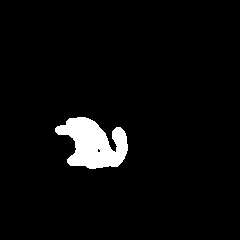

In [58]:
mask = Image.open(mask_path).convert('L')
mask

In [34]:
import cv2

In [49]:
for i, heatmap in enumerate(anomaly_map_np):
    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap_path = f"heatmap_{i}.jpg"  # Path to save the heatmap image
    cv2.imwrite(heatmap_path, heatmap_colored)

In [81]:
anomaly_maps[0].shape

torch.Size([1, 240, 240])

In [99]:
anomaly_map_combined = anomaly_maps[0]
for anomaly_map in anomaly_maps[1:]:
    anomaly_map_combined += anomaly_map

combined_tensor_clamped = torch.clamp(anomaly_map_combined, min=0, max=1)
print(torch.max(combined_tensor_clamped))
print(combined_tensor_clamped.shape)

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 240, 240])


In [100]:
anomaly_map_np = (combined_tensor_clamped * 255).squeeze().cpu().detach().numpy().astype(np.uint8)
heatmap_colored = cv2.applyColorMap(anomaly_map_np, cv2.COLORMAP_JET)
heatmap_path = f"heatmap_1.jpg"  # Path to save the heatmap image
cv2.imwrite(heatmap_path, heatmap_colored)

True

255


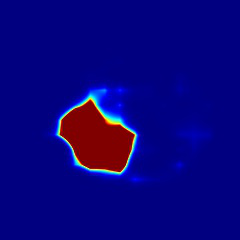

In [101]:
heatmap_path = "./heatmap_1.jpg"
heatmap_img = Image.open(heatmap_path).convert('RGB')
print(np.max(heatmap_img))
heatmap_img

In [37]:
cam_features = anomaly_map_np
cam_features.shape

(240, 240)

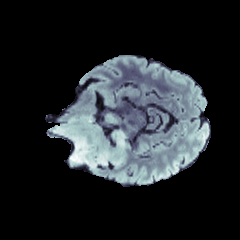

In [63]:
ori_image

In [71]:
ori_image = Image.open(img_path).convert('RGB')
input_image = transform_image(ori_image)
print(np.max(ori_image))
print(torch.max(input_image))
print(input_image.shape)

255
tensor(1.)
torch.Size([3, 240, 240])


In [105]:
ori_image = input_image * 255
ori_image = ori_image.numpy().astype(np.uint8)
ori_image = np.transpose(ori_image, (1, 2, 0))
# cv2.imwrite('output_image.png', np_image)
plt.imsave('output_image.png', ori_image)

255


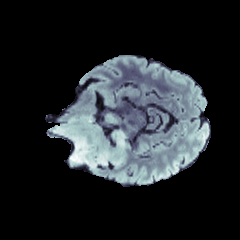

In [106]:
# plt.imsave('output_image.png', ori_image)
check_img_path = "./output_image.png"
check_img = Image.open(check_img_path).convert('RGB')
print(np.max(check_img))
check_img

In [107]:
Normal = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [108]:
print(ori_image.shape)
print(combined_tensor_clamped.shape)

(240, 240, 3)
torch.Size([1, 240, 240])


In [116]:
cam_feature = combined_tensor_clamped.squeeze().cpu().detach().numpy()
print(cam_feature.shape)
print(np.max(cam_feature))

(240, 240)
1.0


In [135]:
crop = np.uint8(cam_feature > 0.2)
print(crop.shape)
print(np.max(crop))
print(np.min(crop))

(240, 240)
1
0


In [138]:
rows_to_keep = np.any(cam_feature > 0.5, axis=1)
cols_to_keep = np.any(cam_feature > 0.5, axis=0)

mask = np.zeros_like(ori_image, dtype=bool)

start_row, end_row = np.where(rows_to_keep)[0][[0, -1]]
start_col, end_col = np.where(cols_to_keep)[0][[0, -1]]
mask[start_row:end_row+1, start_col:end_col+1, :] = True

highlighted_image = np.where(mask, ori_image, 0)
plt.imsave('output_image.png', highlighted_image)

In [136]:
mask = np.zeros_like(ori_image, dtype=bool)
for channel in range(3):
    mask[:, :, channel] = crop
highlighted_image = np.where(mask, ori_image, 0)
plt.imsave('output_image.png', highlighted_image)

255


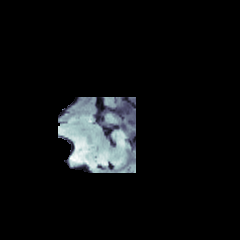

In [139]:
check_img_path = "./output_image.png"
check_img = Image.open(check_img_path).convert('RGB')
print(np.max(check_img))
check_img

In [129]:
ret, markers = cv2.connectedComponents(crop)
print(ret)
print(markers.shape)
print(markers[0][0])

2
(240, 240)
0


In [130]:
branch_size = np.zeros(ret)
h = 240
w = 240
for i in range(h):
    for j in range(w):
        t = int(markers[i][j])
        branch_size[t] += 1
branch_size[0] = 0
print(branch_size)
print(np.argmax(branch_size))

[   0. 3600.]
1


In [131]:
max_branch = np.argmax(branch_size)
mini = h
minj = w
maxi = -1
maxj = -1
for i in range(h):
    for j in range(w):
        if markers[i][j] == max_branch:
            if i < mini:
                mini = i
            if i > maxi:
                maxi = i
            if j < minj:
                minj = j
            if j > maxj:
                maxj = j
local_img = ori_image[mini: maxi + 1, minj: maxj + 1, :]
local_img = cv2.resize(local_img, (240, 240))
local_img = Image.fromarray(local_img)
print(local_img.size)
local_img.save("./output_image.png")

(240, 240)


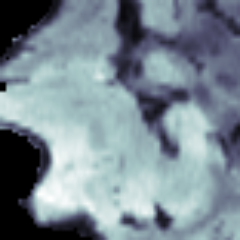

In [132]:
# local_img.
# local_show_img = np.transpose(local_img, (1, 2, 0))
# local_show_img = np.uint8(local_show_img * 255)
# cv2.imwrite('output_image.png', local_show_img)
check_img_path = "./output_image.png"
check_img = Image.open(check_img_path).convert('RGB')
check_img

In [41]:
result1 = localize(heatmap_numpy, mask)
cv2.imwrite("./demo_heatmap_1.jpg", result1)

True